# Решения (Вариант 11)

В блокноте реализованы:
1) BoW и TF-IDF  
2) Логистическая регрессия + метрики

Ограничения: без `scikit-learn`, `torch`, `tensorflow`.


In [1]:
import re
import math
import random
from collections import Counter

import numpy as np

np.random.seed(42)
random.seed(42)

def tokenize_ru(text: str):
    return re.findall(r"[а-яёa-z]+", text.lower())


In [2]:
texts = [
    "Отличный фильм, очень понравилось, рекомендую",
    "Ужасный фильм, скучно и затянуто",
    "Супер сервис, быстро и вежливо",
    "Никому не советую, все плохо и медленно",
    "Классная книга, интересный сюжет",
    "Плохая книга, много воды и скучно",
    "Очень вкусно, приятная атмосфера",
    "Еда отвратительная, больше не приду",
]

y = np.array([1,0,1,0,1,0,1,0], dtype=np.float64)

print("Пример токенизации:", tokenize_ru(texts[0]))
print("Размер датасета:", len(texts))


Пример токенизации: ['отличный', 'фильм', 'очень', 'понравилось', 'рекомендую']
Размер датасета: 8


## Задача 1 — BoW и TF-IDF

In [ ]:
def build_vocab(texts):
    vocab_set = set()
    for t in texts:
        vocab_set.update(tokenize_ru(t))
    tokens_sorted = sorted(vocab_set)
    return {tok: i for i, tok in enumerate(tokens_sorted)}

def vectorize_bow(texts, vocab):
    n = len(texts)
    V = len(vocab)
    X = np.zeros((n, V), dtype=np.int64)
    for i, t in enumerate(texts):
        cnt = Counter(tokenize_ru(t))
        for tok, c in cnt.items():
            j = vocab.get(tok)
            if j is not None:
                X[i, j] = c
    return X

def vectorize_tfidf(texts, vocab):
    N = len(texts)
    V = len(vocab)

    # df
    df = np.zeros(V, dtype=np.float64)
    for t in texts:
        for tok in set(tokenize_ru(t)):
            j = vocab.get(tok)
            if j is not None:
                df[j] += 1.0

    # idf

# ОШИБКА В ФОРМУЛЕ
#    idf = np.log((N) / (df + 1.0)) + 1.0

    idf = np.log((N + 1.0) / (df + 1.0)) + 1.0 # ИСПРАВЛЕННАЯ ВЕРСИЯ

    X = np.zeros((N, V), dtype=np.float64)
    for i, t in enumerate(texts):
        tokens = tokenize_ru(t)
        if not tokens:
            continue
        cnt = Counter(tokens)
        denom = float(max(cnt.values()))
        for tok, c in cnt.items():
            j = vocab.get(tok)
            if j is not None:
                tf = c / denom
                X[i, j] = tf * idf[j]
    return X


In [4]:
# Проверка формы
vocab = build_vocab(texts)
X_bow = vectorize_bow(texts, vocab)
X_tfidf = vectorize_tfidf(texts, vocab)

print("Размер словаря:", len(vocab))
print("X_bow:", X_bow.shape, "X_tfidf:", X_tfidf.shape)

print("BoW min/max:", int(X_bow.min()), int(X_bow.max()))
print("TF-IDF min/max:", float(X_tfidf.min()), float(X_tfidf.max()))


Размер словаря: 33
X_bow: (8, 33) X_tfidf: (8, 33)
BoW min/max: 0 1
TF-IDF min/max: 0.0 2.386294361119891


## Задача 2 — Логистическая регрессия + метрики

In [ ]:
def sigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z, dtype=np.float64)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out

def bce_loss(y_true, y_proba, eps=1e-12):
    y_true = np.asarray(y_true, dtype=np.float64).reshape(-1)
    y_proba = np.asarray(y_proba, dtype=np.float64).reshape(-1)
    p = np.clip(y_proba, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(p) + (1.0 - y_true) * np.log(1.0 - p))

def predict_proba(X, w, b):
    return sigmoid(X @ w + b)

def predict(X, w, b, threshold=0.5):
    return (predict_proba(X, w, b) >= threshold).astype(int)

def metrics_binary(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_pred = np.asarray(y_pred).astype(int).reshape(-1)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    # ОШИБКА В ФОРМУЛАХ МЕТРИК
#    precision = tp / max(1, (tp + fn))
#    recall = tp / max(1, (tp + fp))

    precision = tp / max(1, (tp + fp)) # ИСПРАВЛЕННЫЕ ФОРМУЛЫ
    recall = tp / max(1, (tp + fn))

    f1 = 0.0 if (precision + recall) == 0 else 2.0 * precision * recall / (precision + recall)

    return {
        "accuracy": float(acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }

def fit_logreg(X, y, lr=0.2, epochs=600):
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64).reshape(-1)

    N, d = X.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0
    history = []

    for _ in range(epochs):
        y_hat = predict_proba(X, w, b)
        loss = bce_loss(y, y_hat)
        history.append(float(loss))
# ОШИБКА. НЕПРАВИЛЬНАЯ ФОРМУЛА ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
#        dz = (y_hat - y) * (y_hat * (1.0 - y_hat)) / N
        dz = (y_hat - y) / N # ИСПРАВЛЕННАЯ ФОРМУЛА
        dw = X.T @ dz
        db = float(np.sum(dz))

        w -= lr * dw
        b -= lr * db

    return w, b, history


In [6]:
X = X_tfidf

w, b, history = fit_logreg(X, y, lr=0.2, epochs=800)

y_proba = predict_proba(X, w, b)
y_pred = predict(X, w, b, threshold=0.5)

print("loss:", float(bce_loss(y, y_proba)))
print("metrics:", metrics_binary(y, y_pred))
print("proba:", np.round(y_proba, 3))


loss: 0.034397246812290894
metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 4, 'fp': 0, 'tn': 4, 'fn': 0}
proba: [0.966 0.037 0.963 0.026 0.961 0.033 0.967 0.032]


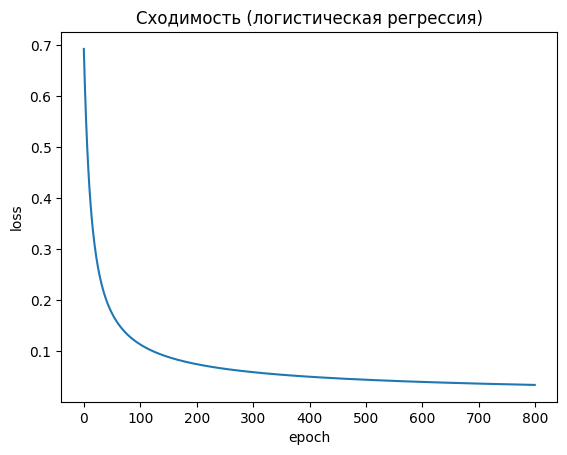

In [7]:
# График динамики loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Сходимость (логистическая регрессия)")
plt.show()
